In [74]:
import pandas as pd
from tabulate import tabulate
class Trader:
    def __init__(self,initial_balance,sl_points,RiskToReward):
        self.balance = initial_balance
        self.RiskToReward  = RiskToReward
        self.sl_points = sl_points
        self.trad_book = pd.DataFrame(columns=['IndexName', 'TradSide', 'Status', 'Quantity', 'BuyPrice',
                                               'BuyDatetime', 'SellPrice', 'SellDatetime','SLValue',
                                               'TargetValue', 'PnL Status','PnL'])
        

    def backtest(self, df):
        open_order = None
        TradSide = None
        tg_order = None
        sl_order = None

        for index, row in df.iterrows():
            if row["TradSide"] != "None" and open_order is None:
                open_order = row["Close"]
                TradSide = row["TradSide"]
                sl = self.sl_points * int(self.RiskToReward.split(":")[0])
                tg = sl * int(self.RiskToReward.split(":")[1])
                sl_order, tg_order = (open_order - sl, open_order + tg) if TradSide == "CE" else (open_order + sl, open_order - tg)
                symbol = "Nifty50"
                quantity = 10
                new_log = pd.DataFrame({'IndexName': [symbol],'TradSide':[TradSide],'Status':["Open"] ,'Quantity': [quantity], 'BuyPrice': [open_order],
                                'BuyDatetime': [row["Datetime"]], 'SellDatetime': [None], 'SellPrice': [None],
                                'PnL': [0],'SLValue': [sl_order], 'TargetValue': [tg_order], 'PnL Status': [None] })
                self.trad_book = pd.concat([self.trad_book, new_log], ignore_index=True)
            if open_order is not None:
                if (TradSide == "CE" and (row["Close"] >= tg_order or row["Close"] <= sl_order)) or \
                   (TradSide == "PE" and (row["Close"] <= tg_order or row["Close"] >= sl_order)):
                    pnl = row["Close"] - open_order if TradSide == "CE" else open_order - row["Close"]
                    self.balance += pnl
                    
                    index = self.trad_book.shape[0] -1
                    self.trad_book.at[index, 'SellPrice'] = row["Close"]
                    self.trad_book.at[index, 'SellDatetime'] = row["Datetime"]
                    self.trad_book.at[index, 'Status'] = "Done"
                    self.trad_book.at[index, 'PnL'] = pnl
                    self.trad_book.at[index, 'PnL Status'] = "Profit" if  pnl >0  else "Loss"
                    self.trad_book.at[index, 'SellDatetime'] = row["Datetime"]
                    open_order = None

    
    def stats(self):
            df = self.trad_book
            total_trade = len(df.index)
            pnl = df.PnL.sum()
            winners = len(df[df.PnL > 0])
            losers = len(df[df.PnL <= 0])
            win_ratio = round((winners / total_trade) * 100, 2)
    
            # Calculate CE and PE trades
        
            ce_trades = f"{(len(df[(df['TradSide'] == 'CE') & (df['PnL'] > 0)]) / len(df[df['TradSide'] == 'CE']) * 100):.2f}%" if len(df[df['TradSide'] == 'CE']) != 0 else 0
            pe_trades = f"{(len(df[(df['TradSide'] == 'PE') & (df['PnL'] > 0)]) / len(df[df['TradSide'] == 'PE']) * 100):.2f}%" if len(df[df['TradSide'] == 'PE']) != 0 else 0

    
            # Calculate additional metrics
            capital = self.balance
            max_win = round(df[df.PnL > 0].PnL.max(), 2) if winners > 0 else 0
            max_profit_sum = round(df[df.PnL > 0].PnL.sum(), 2) if winners > 0 else 0
            max_loss = round(df[df.PnL <= 0].PnL.min(), 2) if losers > 0 else 0
            max_loss_sum = round(df[df.PnL <= 0].PnL.sum(), 2) if losers > 0 else 0
            total_profit = round(df.PnL.sum(), 2)
            total_profit_percentage = round((total_profit / self.balance) * 100, 2)
            trading_days = pd.to_datetime(df['BuyDatetime']).dt.strftime('%Y%m%d').nunique()

    
            # Prepare the data for tabular representation
            # parameters = ['Total Trades', 'Capital', 'Total Wins', 'Total Losses', 'Win Ratio',
            #               'Max Win', 'Max Win Score','Max Loss', 'Max Loss Score','Total Profit', ' Grow Profit %',
            #               'CE Trades', 'PE Trades', 'Stategy Name']


            parameters = ['Total Trading Days','Total Trades','RiskToReward','Base SL','Capital', 'Total Wins', 'Total Losses', 'Win Ratio','Total Profit', 'Grow Profit %',
                              'Max Win', 'Max Win Score','Max Loss', 'Max Loss Score','CE Trades', 'PE Trades', 'Stategy Name']


        
            data_points = [trading_days,total_trade, self.RiskToReward ,self.sl_points,capital, winners, losers, f"{win_ratio}%",total_profit,f"{total_profit_percentage}%",
                           max_win, max_profit_sum,max_loss, max_loss_sum,ce_trades, pe_trades, "Test"]

        
            data = list(zip(parameters, data_points))
    
            # Print the tabular representation
            print(tabulate(data, headers=['Parameters', 'Values'], tablefmt='psql'))
    
            excel_file = "statistics.csv"
            try:
                existing_df = pd.read_csv(excel_file)
                new_data = pd.DataFrame([data_points], columns=parameters)
                updated_df = pd.concat([existing_df, new_data], ignore_index=True)
                updated_df.to_csv(excel_file, index=False)
            except FileNotFoundError:
                new_data = pd.DataFrame([data_points], columns=parameters)
                new_data.to_csv(excel_file, index=False)

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("Sensex15.csv")

In [76]:
df['Prev_Candle_Signal'] =df['Candle_Signal'].shift(1)
df['Prev_Candle'] = df['Candle'].shift(1)
df = df.reindex(sorted(df.columns), axis=1)

In [104]:
ce_condition = ((df['High'].shift(1) < df['15EMA'].shift(1)) & (df["Close"] > df['15EMA'])
                # &(df["SuperTrend"] == 1)
                &(df["Prev_Candle_Signal"] == "Bullish")
               )

pe_condition = ((df['Low'].shift(1) > df['15EMA'].shift(1)) & (df["Close"] < df['15EMA'])
                # &(df["SuperTrend"] == -1)
                &(df["Prev_Candle_Signal"] == "Bearish")
               )

df['TradSide'] = np.select([ce_condition, pe_condition], ['CE', 'PE'], default='None')

In [115]:
trader = Trader(initial_balance = 100000,sl_points = 100,RiskToReward = "1:4")
trader.backtest(df)
trader.stats()

+--------------------+--------------------+
| Parameters         | Values             |
|--------------------+--------------------|
| Total Trading Days | 240                |
| Total Trades       | 269                |
| RiskToReward       | 1:4                |
| Base SL            | 100                |
| Capital            | 108281.70999999998 |
| Total Wins         | 76                 |
| Total Losses       | 193                |
| Win Ratio          | 28.25%             |
| Total Profit       | 8281.71            |
| Grow Profit %      | 7.65%              |
| Max Win            | 1728.8             |
| Max Win Score      | 41892.61           |
| Max Loss           | -1044.9            |
| Max Loss Score     | -33610.9           |
| CE Trades          | 27.86%             |
| PE Trades          | 28.68%             |
| Stategy Name       | Test               |
+--------------------+--------------------+


In [102]:
# EMA
# +--------------------+--------------------+
# | Parameters         | Values             |
# |--------------------+--------------------|
# | Total Trading Days | 387                |
# | Total Trades       | 505                |
# | RiskToReward       | 1:4                |
# | Base SL            | 100                |
# | Capital            | 109021.17999999995 |
# | Total Wins         | 140                |
# | Total Losses       | 365                |
# | Win Ratio          | 27.72%             |
# | Total Profit       | 9021.18            |
# | Grow Profit %      | 8.27%              |
# | Max Win            | 1728.8             |
# | Max Win Score      | 75317.37           |
# | Max Loss           | -1044.9            |
# | Max Loss Score     | -66296.19          |
# | CE Trades          | 28.11%             |
# | PE Trades          | 27.34%             |
# | Stategy Name       | Test               |
# +--------------------+--------------------+

In [106]:
# EMA-PREVIES CANLDE
# +--------------------+--------------------+
# | Parameters         | Values             |
# |--------------------+--------------------|
# | Total Trading Days | 240                |
# | Total Trades       | 269                |
# | RiskToReward       | 1:4                |
# | Base SL            | 100                |
# | Capital            | 108281.70999999998 |
# | Total Wins         | 76                 |
# | Total Losses       | 193                |
# | Win Ratio          | 28.25%             |
# | Total Profit       | 8281.71            |
# | Grow Profit %      | 7.65%              |
# | Max Win            | 1728.8             |
# | Max Win Score      | 41892.61           |
# | Max Loss           | -1044.9            |
# | Max Loss Score     | -33610.9           |
# | CE Trades          | 27.86%             |
# | PE Trades          | 28.68%             |
# | Stategy Name       | Test               |
# +--------------------+--------------------+

In [107]:
# EMA-SUPERTRAND-PREVIES DAY
# +--------------------+--------------------+
# | Parameters         | Values             |
# |--------------------+--------------------|
# | Total Trading Days | 111                |
# | Total Trades       | 117                |
# | RiskToReward       | 1:4                |
# | Base SL            | 100                |
# | Capital            | 107960.19000000005 |
# | Total Wins         | 39                 |
# | Total Losses       | 78                 |
# | Win Ratio          | 33.33%             |
# | Total Profit       | 7960.19            |
# | Grow Profit %      | 7.37%              |
# | Max Win            | 1728.8             |
# | Max Win Score      | 21063.29           |
# | Max Loss           | -803.0             |
# | Max Loss Score     | -13103.1           |
# | CE Trades          | 32.26%             |
# | PE Trades          | 34.55%             |
# | Stategy Name       | Test               |
# +--------------------+--------------------+

In [108]:
tk = trader.trad_book
tk

IndexName TradSide Status Quantity  BuyPrice          BuyDatetime  \
0     Nifty50       CE   Done       10  57424.60  2021-11-29 11:00:00   
1     Nifty50       CE   Done       10  57708.70  2021-12-01 09:15:00   
2     Nifty50       CE   Done       10  57625.90  2021-12-01 14:30:00   
3     Nifty50       CE   Done       10  58546.10  2021-12-09 10:45:00   
4     Nifty50       PE   Done       10  58044.00  2021-12-14 13:45:00   
..        ...      ...    ...      ...       ...                  ...   
264   Nifty50       PE   Done       10  74805.92  2024-04-30 14:45:00   
265   Nifty50       CE   Done       10  73948.16  2024-05-03 15:00:00   
266   Nifty50       PE   Done       10  74043.83  2024-05-06 11:15:00   
267   Nifty50       CE   Done       10  73581.81  2024-05-07 13:30:00   
268   Nifty50       CE   Done       10  72759.28  2024-05-13 13:45:00   

    SellPrice         SellDatetime   SLValue  TargetValue PnL Status     PnL  
0     57231.8  2021-11-29 14:15:00  57324.60     57824.60       Loss  -192.8  
1     57535.3  2021-12-01 09:30:00  57608.70     58108.70       Loss  -173.4  
2     58086.7  2021-12-02 10:00:00  57525.90     58025.90     Profit   460.8  
3     58443.8  2021-12-10 13:15:00  58446.10     58946.10       Loss  -102.3  
4     57619.0  2021-12-17 09:15:00  58144.00     57644.00     Profit   425.0  
..        ...                  ...       ...          ...        ...     ...  
264  75074.65  2024-05-03 09:15:00  74905.92     74405.92       Loss -268.73  
265  73845.76  2024-05-03 15:15:00  73848.16     74348.16       Loss  -102.4  
266  74150.68  2024-05-06 12:00:00  74143.83     73643.83       Loss -106.85  
267  73366.26  2024-05-07 14:15:00  73481.81     73981.81       Loss -215.55  
268  73167.07  2024-05-14 13:30:00  72659.28     73159.28     Profit  407.79  

[269 rows x 12 columns]

In [124]:
ViewList = ["Datetime", "Day_Prev_Candle_Signal", "Day_Prev_Candle", "Day_RSI", "RSI", "Prev_Candle_Signal", "Prev_Candle", "TradSide"]
row_data = df[df["Datetime"].isin(tk["BuyDatetime"])].merge(tk[["BuyDatetime", "PnL Status"]], left_on="Datetime", right_on="BuyDatetime", how="inner")[ViewList + ["PnL Status"]]

In [143]:
p = row_data[(row_data["PnL Status"] == "Loss" )& (row_data["TradSide"] == "CE" )]

<Axes: >

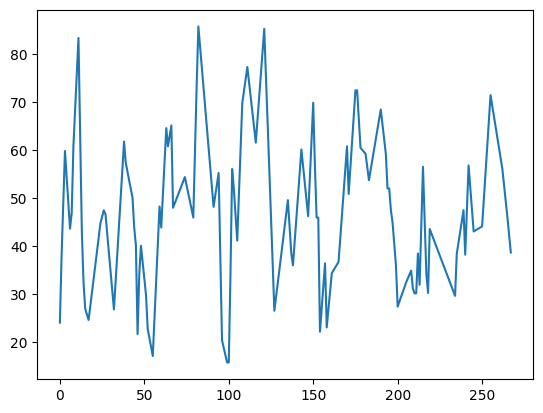

In [144]:
p["Day_RSI"].plot()